# Stat 5241 Statistical Machine Learning Final Project
## Author: Gexin Chen     Uni: gc2936

#  I. BackGround

<font size="3">The MNIST database of handwritten digits is one of the most commonly used dataset for training
various image processing systems and machine learning algorithms. MNIST has a training set of
60,000 examples, and a test set of 10,000 examples. It is a good database for people who want to
try learning techniques and pattern recognition methods on real-world data while spending minimal
efforts on preprocessing and formatting.
MNIST is a subset of a larger set available from NIST. The digits have been size-normalized
and centered in a fixed-size image. The original black and white (bilevel) images from NIST were
size normalized. The resulting images contain grey levels as a result of the anti-aliasing technique
used by the normalization algorithm. The images were centered in a 28 ×28 image by computing
the center of mass of the pixels, and translating the image so as to position this point at the center
of the 28 ×28 field.</font>

# II. Data Processing

In [ ]:
# Import Required Packages
import time
import pandas as pd
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import BatchSampler

In [ ]:
# Data download and preprocessing

DOWNLOAD_MNIST = True # If already download , set as False
train_data = MNIST(
 root='../data/mnist/',
 train=True , # this is training data
 #transform=torchvision.transforms.ToTensor (),
 download=DOWNLOAD_MNIST ,
 )

test_data = MNIST(root='../data/ mnist/', train=False, download=DOWNLOAD_MNIST)

 # change the features to numpy
X_train = train_data.train_data.numpy()
X_test = test_data.test_data.numpy ()

 # change the labels to numpy
Y_train = train_data.train_labels.numpy()
Y_test = test_data.test_labels.numpy ()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## 1.(a)

3


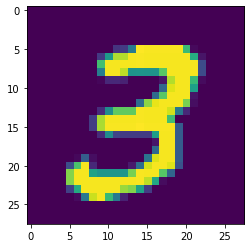

In [ ]:
# Plot The Feature Parameters
imshow(X_train[7]);

# Return the Output 
print(Y_train[7])

<font size = 3>From above image, we can see the number is '3' which matches the label in Y_train.

## 1.(b)

In [ ]:
# Check Dimensions
[shape(X_test),shape(X_train)]

[(10000, 28, 28), (60000, 28, 28)]

In [ ]:
# Data Reshape
X_train = X_train.reshape(-1,28*28)
X_test = X_test.reshape(-1, 28*28)

In [ ]:
# Data Normalization
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

## 1.(c)

In [ ]:
# One Hot Encoding
onehot = preprocessing.OneHotEncoder(sparse = False)
onehot.fit(Y_train.reshape(-1,1))
Y_train_oh = onehot.transform(Y_train.reshape(-1,1))
Y_test_oh = onehot.transform(Y_test.reshape(-1,1))

One hot embedding transfer every labels to 1*N matrix containing only 0 and 1. In this way, each label can be treated equally by machine learning algorithm, which is difficult to be achieved by using numerical values to represent classes.

# III. Before Deep Learning

##  2.(a)

In [ ]:
# KNN Training With K = 3
KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train_oh)

In [ ]:
1 - KNN.score(X_test, Y_test_oh)

0.02729999999999999

In [ ]:
# Adaboost Training
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=30).fit(X_train, Y_train)

In [ ]:
1 - ada.score(X_test, Y_test)

0.03720000000000001

In [ ]:
dt = DecisionTreeClassifier(max_depth = 20).fit(X_train, Y_train)

In [ ]:
1 - dt.score(X_test, Y_test)

0.11280000000000001

In [ ]:
# SVM with Gaussian Kernel
svm = SVC().fit(X_train, Y_train)

In [ ]:
1 - svm.score(X_test, Y_test)

0.018900000000000028

From above, we can see that the test errors of all three algorithms are different from the given result.   
KNN: 2.73% Test Error vs. 5% Desired Test Error  
AdaBoost.M1: 3.72% Test Error vs. 4.05% Desired Test Error  
Decision Tree: 11.3% Test Error vs. 4.05% Desired Test Error  
SVM with Gaussian Kernel: 1.9% Test Error vs. 1.4% Test Error



It can be caused by multiple reasons:  
1. The data we used above may be different from the data authors used;
2. The preprocessing procedures are different (We have done normalization in Part1);
3. The hyperparameters for the four algorithms may be different (KNN with K = 3, AdaBoost & Decision Tree with maximum depth = 20, SVM with C = 1);  
4. The train test split method applied on the dataset may be different.

## 2.(b)

In [ ]:
#SVM with Gaussian Kernel
svm1 = SVC(C = 2).fit(X_train, Y_train)
1 - svm1.score(X_test, Y_test)

0.015800000000000036

From above, we can see that the testing error for SVM with Gaussian Kernel with C = 2 is 1.5%, which is lower than the test errors of all classifiers in part (a).

# IV. Deep Leaning

In [ ]:
# Define Required Plot Function
def loss_plot(train,test):
    index = []
    train_set = []
    test_set = []
    for i in range(len(train)):
        index.append(i+1)
        train_set.append(train[i][0])
        test_set.append(test[i][0])
    plt.plot(index, train_set, label = "Train")
    plt.plot(index, test_set, label = "Test")
    plt.legend()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss Function")
    plt.title("Loss vs. Epochs Plot")
    
def error_plot(train,test):
    index = []
    train_set = []
    test_set = []
    for i in range(len(train)):
        index.append(i+1)
        train_set.append(1 - train[i][1])
        test_set.append(1 - test[i][1])
    plt.plot(index, train_set, label = "Train")
    plt.plot(index, test_set, label = "Test")
    plt.legend()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Classification Error")
    plt.title("Classification Error vs. Epochs Plot")

In [ ]:
# Use Better-performance GPU If Avaliable
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
# Data Type Transformation & Normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Read Data
train_data = MNIST(root='../data/mnist/', train=True, download=True, transform = transform)

test_data = MNIST(root='../data/ mnist/', train=False, download=True, transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/ mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/ mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/ mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/ mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/ mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/ mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/ mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/ mnist/MNIST/raw



## 3.(a) &  (b)

In [ ]:
# Create a Fully Connected Neural Network With Linear Layer
class ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        # 100 Hidden Neurons
        self.layer1 = nn.Linear(input_size, 100)
        # 10 Output Classes
        self.layer2 = nn.Linear(100, num_classes)
   
    def forward(self, x):
        x = self.flatten(x)
        # Sigmoid As Activation Function
        x = torch.sigmoid(self.layer1(x))
        x = self.layer2(x)
        return x

In [ ]:
# Two Functions Below can be Utilized From Part 3 to Part 5
# Define Training Process
def train_loop(dataloader, model, loss_fn, optimizer):
    running_loss, correct = 0, 0
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss = running_loss / size
    correct /= size
    print('Training loss: {}'.format(running_loss))
    print('Training accuracy: {}'.format(correct))
    return running_loss, correct

# Define Test Loss And Accuracy Calculation
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print('Testing loss: {}'.format(test_loss))
    print('Testing accuracy: {}'.format(correct))
    return test_loss, correct

### Seed 1

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
model1 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    # Record Errors and Accuracy For Each Epoch
    train_loss_record.append(train_loop(train_loader,model1,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model1,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.6297853591203689
Training accuracy: 0.8404333333333334
Testing loss: 0.3246687440925343
Testing accuracy: 0.9099
Epoch 2
-------------------------------
Training loss: 0.3062173386176427
Training accuracy: 0.90985
Testing loss: 0.2625952813845531
Testing accuracy: 0.9232
Epoch 3
-------------------------------
Training loss: 0.2574633126338323
Training accuracy: 0.9253666666666667
Testing loss: 0.2444920286441305
Testing accuracy: 0.9279
Epoch 4
-------------------------------
Training loss: 0.22505092318455377
Training accuracy: 0.9355166666666667
Testing loss: 0.20499181634135497
Testing accuracy: 0.9398
Epoch 5
-------------------------------
Training loss: 0.19978262469768523
Training accuracy: 0.9427833333333333
Testing loss: 0.19584464236714277
Testing accuracy: 0.9426
Epoch 6
-------------------------------
Training loss: 0.18053489449024201
Training accuracy: 0.9485166666666667
Testing loss: 0.1671521149243519
Testing acc

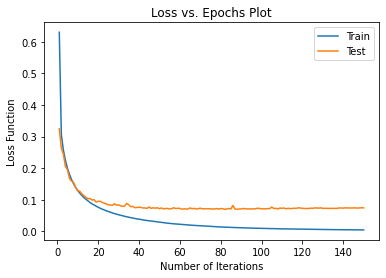

In [ ]:
# Plot the Cross Entropy Loss
loss_plot(train_loss_record, test_loss_record)

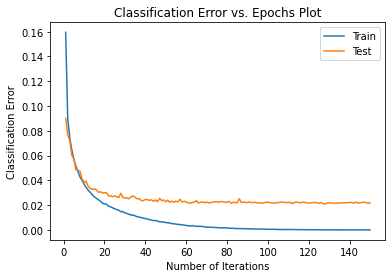

In [ ]:
# Plot Classification Error
error_plot(train_loss_record, test_loss_record)

### Seed 2

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
model2 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(2) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model2,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model2,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.6285737864812215
Training accuracy: 0.83575
Testing loss: 0.32961231640949373
Testing accuracy: 0.9084
Epoch 2
-------------------------------
Training loss: 0.3063160417238871
Training accuracy: 0.9112166666666667
Testing loss: 0.27231808049473794
Testing accuracy: 0.9221
Epoch 3
-------------------------------
Training loss: 0.2572185028076172
Training accuracy: 0.9245666666666666
Testing loss: 0.2324833566690706
Testing accuracy: 0.9329
Epoch 4
-------------------------------
Training loss: 0.22372442430655162
Training accuracy: 0.9354666666666667
Testing loss: 0.213163637336652
Testing accuracy: 0.937
Epoch 5
-------------------------------
Training loss: 0.19896439953446388
Training accuracy: 0.9425833333333333
Testing loss: 0.18708855639787236
Testing accuracy: 0.945
Epoch 6
-------------------------------
Training loss: 0.17874435766935348
Training accuracy: 0.9482
Testing loss: 0.17481042874182107
Testing accuracy: 0.9477

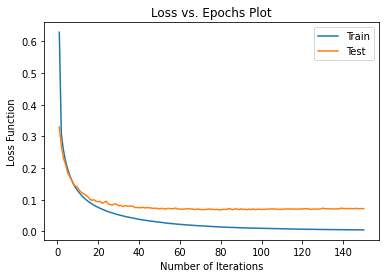

In [ ]:
loss_plot(train_loss_record, test_loss_record)

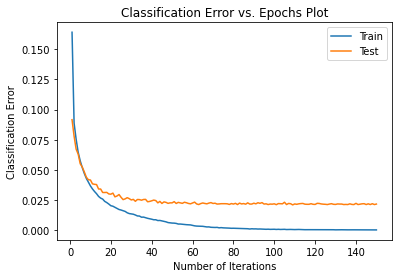

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Seed 3

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
model3 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(3) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model3,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model3,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.6275367340485255
Training accuracy: 0.8404666666666667
Testing loss: 0.31873518200057327
Testing accuracy: 0.9077
Epoch 2
-------------------------------
Training loss: 0.30368664303620657
Training accuracy: 0.9121166666666667
Testing loss: 0.2614467456747013
Testing accuracy: 0.925
Epoch 3
-------------------------------
Training loss: 0.2540707253257434
Training accuracy: 0.92645
Testing loss: 0.2231266686728426
Testing accuracy: 0.9374
Epoch 4
-------------------------------
Training loss: 0.2208526145418485
Training accuracy: 0.9356666666666666
Testing loss: 0.204401060369364
Testing accuracy: 0.9401
Epoch 5
-------------------------------
Training loss: 0.1954198545495669
Training accuracy: 0.94395
Testing loss: 0.18842660322500643
Testing accuracy: 0.9439
Epoch 6
-------------------------------
Training loss: 0.1762587542394797
Training accuracy: 0.9491166666666667
Testing loss: 0.17103185219939349
Testing accuracy: 0.9509


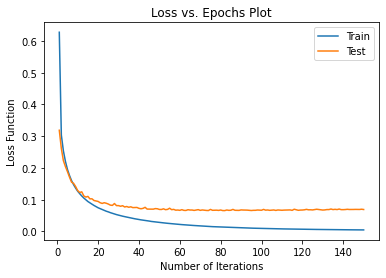

In [ ]:
loss_plot(train_loss_record, test_loss_record)

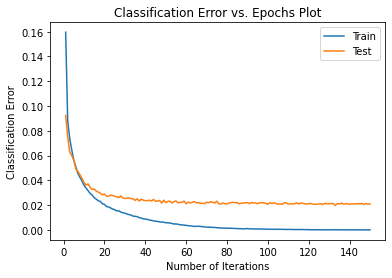

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Seed 4

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
model4 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model4.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(4) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model4,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model4,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.6387938571135203
Training accuracy: 0.8376833333333333
Testing loss: 0.327108277257081
Testing accuracy: 0.9088
Epoch 2
-------------------------------
Training loss: 0.3063377214113871
Training accuracy: 0.9117166666666666
Testing loss: 0.2847654082023414
Testing accuracy: 0.919
Epoch 3
-------------------------------
Training loss: 0.2570360112428665
Training accuracy: 0.9252833333333333
Testing loss: 0.24353571131730536
Testing accuracy: 0.9284
Epoch 4
-------------------------------
Training loss: 0.22377142219344776
Training accuracy: 0.9352166666666667
Testing loss: 0.20938302626370625
Testing accuracy: 0.9386
Epoch 5
-------------------------------
Training loss: 0.19823398996591568
Training accuracy: 0.9429666666666666
Testing loss: 0.1897248747242484
Testing accuracy: 0.9414
Epoch 6
-------------------------------
Training loss: 0.17865585875908535
Training accuracy: 0.9485
Testing loss: 0.17651596084047275
Testing accur

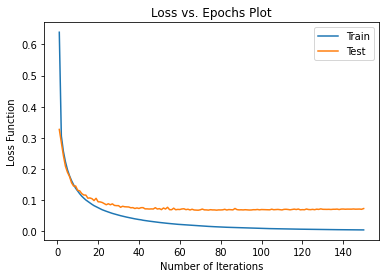

In [ ]:
loss_plot(train_loss_record, test_loss_record)

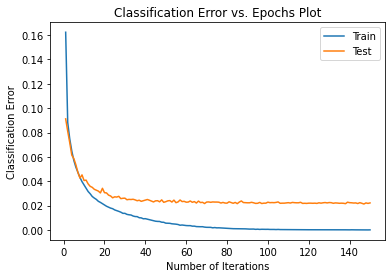

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Seed 5

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
model5 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model5.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(5) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.6322024107138315
Training accuracy: 0.83795
Testing loss: 0.33491543362474746
Testing accuracy: 0.9038
Epoch 2
-------------------------------
Training loss: 0.30600347589651744
Training accuracy: 0.9118333333333334
Testing loss: 0.27709104132595336
Testing accuracy: 0.9228
Epoch 3
-------------------------------
Training loss: 0.2575241854429245
Training accuracy: 0.9256833333333333
Testing loss: 0.23937038567130733
Testing accuracy: 0.9305
Epoch 4
-------------------------------
Training loss: 0.2254486405332883
Training accuracy: 0.9345666666666667
Testing loss: 0.21035708320938099
Testing accuracy: 0.9388
Epoch 5
-------------------------------
Training loss: 0.20008997386693955
Training accuracy: 0.94155
Testing loss: 0.18809371211441459
Testing accuracy: 0.9436
Epoch 6
-------------------------------
Training loss: 0.18083900736371677
Training accuracy: 0.9475166666666667
Testing loss: 0.16897280246114274
Testing accuracy: 

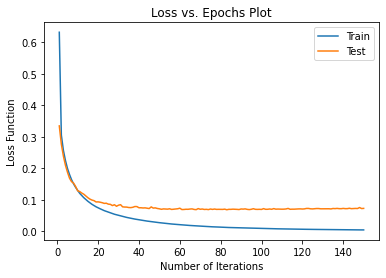

In [ ]:
loss_plot(train_loss_record, test_loss_record)

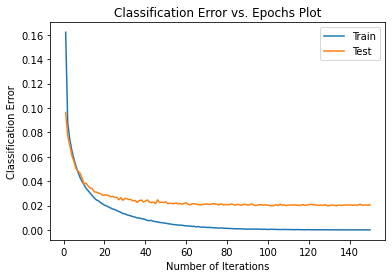

In [ ]:
error_plot(train_loss_record, test_loss_record)

## 3.(c)

We choose our best paramaters based on the highest testing accuracy and lowest loss on test set, which is the parameters set from seed 3.  
Testing Accuracy:  
Seed 1: 97.8%;  
Seed 2: 97.85%;  
Seed 3: 97.91%;  
Seed 4: 97.78%;  
Seed 5: 97.93%.

In [ ]:
# Check the dimension of First Layer Wights
model3.state_dict()['layer1.weight'].shape

torch.Size([100, 784])

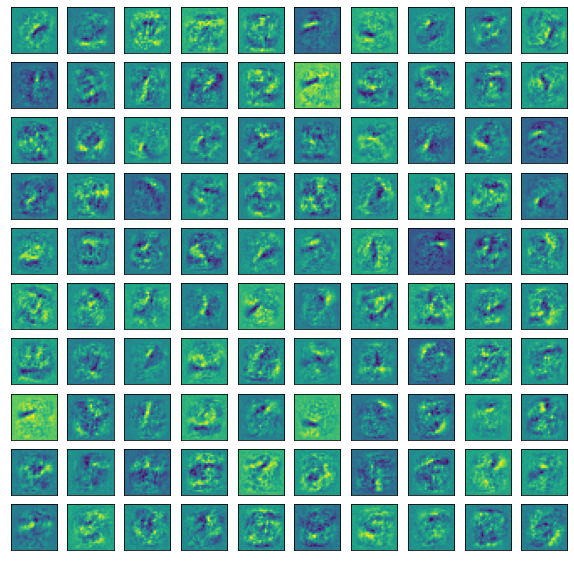

In [ ]:
# Return the Weights for First Linear Layers (784 * 100)
weights = model3.state_dict()['layer1.weight']
plt.figure(figsize = (10,10))
for i in range(weights.shape[0]):
  plt.subplot(10,10,i+1)
  # Total of 100 figures of dimension 28 * 28
  plt.imshow(weights[i].reshape(28,28))
  plt.xticks([]) 
  plt.yticks([])

## 3.(d)

### Learning Rate = 0.01

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.01 
batch_size = 64
num_epochs = 150
model_lr01 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_lr01.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model_lr01,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model_lr01,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 1.7808692644755046
Training accuracy: 0.60885
Testing loss: 1.206184435042606
Testing accuracy: 0.7893
Epoch 2
-------------------------------
Training loss: 0.9264847495714823
Training accuracy: 0.81615
Testing loss: 0.7096677456691767
Testing accuracy: 0.8467
Epoch 3
-------------------------------
Training loss: 0.6306786789258321
Training accuracy: 0.8559166666666667
Testing loss: 0.5391353943924995
Testing accuracy: 0.8757
Epoch 4
-------------------------------
Training loss: 0.511672999827067
Training accuracy: 0.8752833333333333
Testing loss: 0.45568568140837795
Testing accuracy: 0.8859
Epoch 5
-------------------------------
Training loss: 0.4484058856010437
Training accuracy: 0.8844
Testing loss: 0.4096206498753493
Testing accuracy: 0.8949
Epoch 6
-------------------------------
Training loss: 0.4093689453919729
Training accuracy: 0.8922166666666667
Testing loss: 0.37811679587622354
Testing accuracy: 0.8997
Epoch 7
------

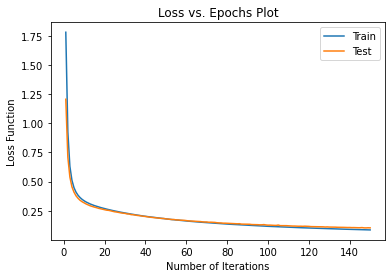

In [ ]:
loss_plot(train_loss_record, test_loss_record)

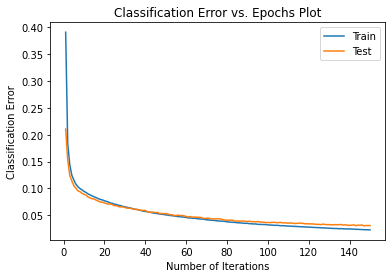

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Learning Rate = 0.2

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.2
batch_size = 64
num_epochs = 150
model_lr2 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_lr2.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model_lr2,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model_lr2,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.4925297539154688
Training accuracy: 0.8610333333333333
Testing loss: 0.2701097254160863
Testing accuracy: 0.9235
Epoch 2
-------------------------------
Training loss: 0.25443291803995766
Training accuracy: 0.9249
Testing loss: 0.20727835612217332
Testing accuracy: 0.9378
Epoch 3
-------------------------------
Training loss: 0.20102468764384587
Training accuracy: 0.9416666666666667
Testing loss: 0.19862253370748204
Testing accuracy: 0.9387
Epoch 4
-------------------------------
Training loss: 0.1674269131700198
Training accuracy: 0.95095
Testing loss: 0.15315754612563712
Testing accuracy: 0.9538
Epoch 5
-------------------------------
Training loss: 0.14438400362531345
Training accuracy: 0.9577833333333333
Testing loss: 0.14660975853111713
Testing accuracy: 0.9555
Epoch 6
-------------------------------
Training loss: 0.12727981328368188
Training accuracy: 0.9636666666666667
Testing loss: 0.1204746461052234
Testing accuracy: 0.

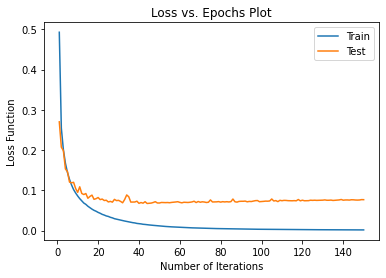

In [ ]:
loss_plot(train_loss_record, test_loss_record)

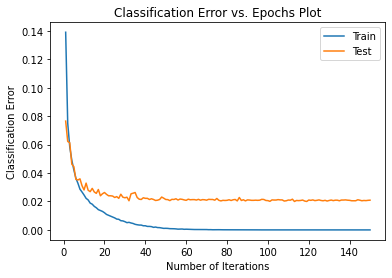

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Learning Rate = 0.5

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.5
batch_size = 64
num_epochs = 150
model_lr5 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_lr5.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model_lr5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model_lr5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Training loss: 0.4216313532034556
Training accuracy: 0.8694333333333333
Testing loss: 0.2060676057389967
Testing accuracy: 0.9393
Epoch 2
-------------------------------
Training loss: 0.19004056726098062
Training accuracy: 0.94295
Testing loss: 0.1550792233460838
Testing accuracy: 0.9528
Epoch 3
-------------------------------
Training loss: 0.14102522436380385
Training accuracy: 0.9579333333333333
Testing loss: 0.1441990660835698
Testing accuracy: 0.9574
Epoch 4
-------------------------------
Training loss: 0.11476427598098914
Training accuracy: 0.9659166666666666
Testing loss: 0.12140255162765266
Testing accuracy: 0.9615
Epoch 5
-------------------------------
Training loss: 0.0984937423268954
Training accuracy: 0.97095
Testing loss: 0.10719659830781685
Testing accuracy: 0.9654
Epoch 6
-------------------------------
Training loss: 0.08611776315172513
Training accuracy: 0.9748666666666667
Testing loss: 0.10067640834304083
Testing accuracy: 0.9695
Epoch 7
---------------------------

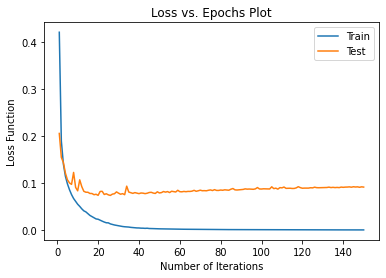

In [ ]:
loss_plot(train_loss_record, test_loss_record)

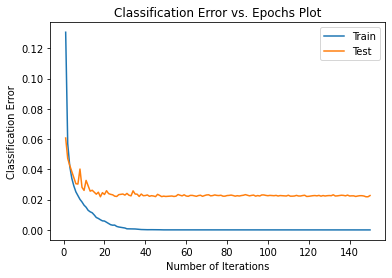

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Momentum = 0.5

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.5
model_m5 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_m5.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model_m5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model_m5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.4837591945886612
Training accuracy: 0.8675333333333334
Testing loss: 0.2681346757301859
Testing accuracy: 0.9243
Epoch 2
-------------------------------
Training loss: 0.2510717252175013
Training accuracy: 0.9259333333333334
Testing loss: 0.20560706098368214
Testing accuracy: 0.9374
Epoch 3
-------------------------------
Training loss: 0.19865883144537608
Training accuracy: 0.9425
Testing loss: 0.18493597396904496
Testing accuracy: 0.9444
Epoch 4
-------------------------------
Training loss: 0.16550074379046759
Training accuracy: 0.9516
Testing loss: 0.15071089562787943
Testing accuracy: 0.9562
Epoch 5
-------------------------------
Training loss: 0.14243549240430195
Training accuracy: 0.9588166666666667
Testing loss: 0.13868545797789933
Testing accuracy: 0.959
Epoch 6
-------------------------------
Training loss: 0.12593183087110518
Training accuracy: 0.9638
Testing loss: 0.11866975684834134
Testing accuracy: 0.965
Epoch 7
-

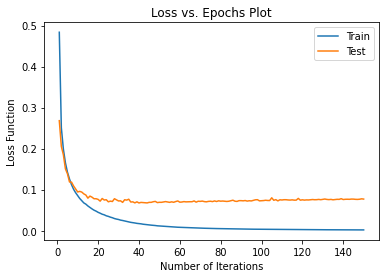

In [ ]:
loss_plot(train_loss_record, test_loss_record)

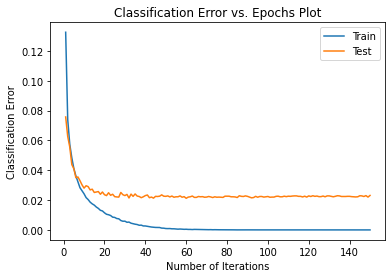

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Momentum = 0.9

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.9
model_m9 = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_m9.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,model_m9,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,model_m9,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.3392916478792826
Training accuracy: 0.8969166666666667
Testing loss: 0.18708914504119545
Testing accuracy: 0.9447
Epoch 2
-------------------------------
Training loss: 0.17288960444529852
Training accuracy: 0.9479333333333333
Testing loss: 0.16911711313637198
Testing accuracy: 0.9486
Epoch 3
-------------------------------
Training loss: 0.1385043405155341
Training accuracy: 0.9576833333333333
Testing loss: 0.13538975030136335
Testing accuracy: 0.9588
Epoch 4
-------------------------------
Training loss: 0.1137163160259525
Training accuracy: 0.96465
Testing loss: 0.12845375989771382
Testing accuracy: 0.9606
Epoch 5
-------------------------------
Training loss: 0.10006115541060766
Training accuracy: 0.9690833333333333
Testing loss: 0.10900107583114106
Testing accuracy: 0.9674
Epoch 6
-------------------------------
Training loss: 0.08733368518749873
Training accuracy: 0.9727833333333333
Testing loss: 0.10248412942857879
Testing

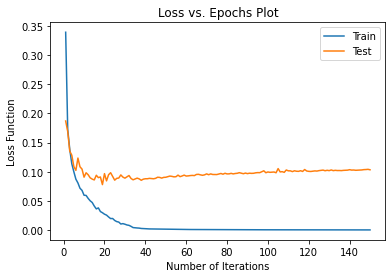

In [ ]:
loss_plot(train_loss_record, test_loss_record)

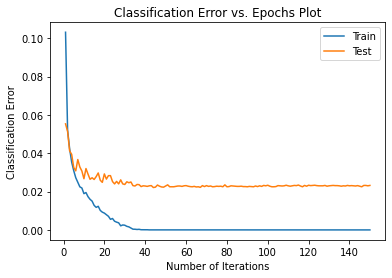

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Best Combination of Hyperparameters

From above plots, it can be observed that:
1. With a total number of 150 epochs, learning rate = 0.2, 0.5, momentum = 0.5, 0.9 combined with learning rate = 0.1, the models all suffer from overfitting. In another word, the testing loss and testing missclassification increase at the end of training process;  
2. With learning rate = 0.01, the convergence process is slow and inefficient.  
Therefore, in terms of efficiency and stability in local minimum, we choose a decaying learning rate which start at 0.2 at the beginning and decay to 0.02 after 30 epochs and 0.002 after 120 epochs to ensure both efficiency and stability.

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.2
batch_size = 64
num_epochs = 150
momentum = 0.5
best_ANN = ANN(input_size, num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(best_ANN.parameters(), lr = learning_rate, momentum = momentum)
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,120], gamma=0.1)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,best_ANN,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,best_ANN,loss))
    scheduler1.step()
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.20079905929168065
Training accuracy: 0.9413833333333333
Testing loss: 0.15954857249595936
Testing accuracy: 0.953
Epoch 2
-------------------------------
Training loss: 0.15190874659021694
Training accuracy: 0.9547166666666667
Testing loss: 0.1338784081659689
Testing accuracy: 0.9596
Epoch 3
-------------------------------
Training loss: 0.12296052929957707
Training accuracy: 0.9639666666666666
Testing loss: 0.12871403236440412
Testing accuracy: 0.9621
Epoch 4
-------------------------------
Training loss: 0.10417695813477039
Training accuracy: 0.9695833333333334
Testing loss: 0.10734542478231868
Testing accuracy: 0.9683
Epoch 5
-------------------------------
Training loss: 0.0911015936901172
Training accuracy: 0.9737833333333333
Testing loss: 0.10990347884073379
Testing accuracy: 0.9664
Epoch 6
-------------------------------
Training loss: 0.08066220927834511
Training accuracy: 0.9766166666666667
Testing loss: 0.09080003348481

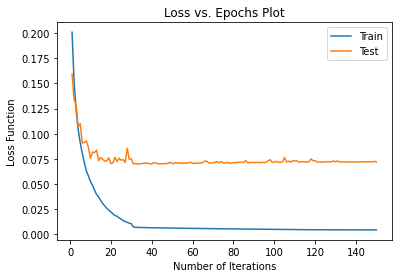

In [ ]:
loss_plot(train_loss_record, test_loss_record)

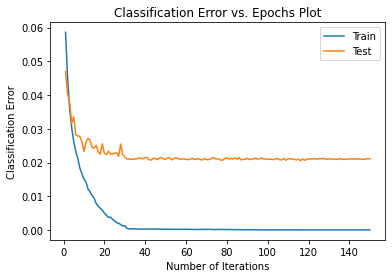

In [ ]:
error_plot(train_loss_record, test_loss_record)

Test Accuracy As Follow:  
Learning Rate = 0.01: 96.92%;  
Learning Rate = 0.2: 97.91%;  
Learning Rate = 0.5: 97.73%;  
Momentum = 0.5 & Learning Rate = 0.1: 97.69%;  
Momentum = 0.9 & Learning Rate = 0.1: 97.68%;
Decaying Learning Rate 0.2/0.02/0.002: 97.89%.
The highest accuracy is obtained from the model with learning rate = 0.2 desipite of the sudden increase in loss and misclassification error. In contrast, decaying learning rate avoid sudden increase in loss and result in high enough accuracy.

## 4.(a) & (b)

In [ ]:
# Create a Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__() # Input Shape 1 * 28 * 28
        self.cv1 = nn.Conv2d(1, 64, 5) # Ouput Shape 64 * 24 * 24
        self.cv2 = nn.Conv2d(64, 16, 3) # Output Shape 16 * 22 * 22
        self.pool1 = nn.MaxPool2d(3, stride = 2) # Output Shape 16 * 10 * 10
        self.fc1 = nn.Linear(1600, 800) # Output Shape 800
        self.fc2 = nn.Linear(800, 256) # Output Shape 256
        self.fc3 = nn.Linear(256, num_classes) # Output Shape: num_classes
   
    def forward(self, x):
        x = F.relu(self.cv1(x))
        x = F.relu(self.cv2(x))
        x = self.pool1(x)
        x = x.reshape(-1, 1600)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    running_loss, correct = 0, 0
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss = running_loss / size
    correct /= size
    print('Training loss: {}'.format(running_loss))
    print('Training accuracy: {}'.format(correct))
    return running_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print('Testing loss: {}'.format(test_loss))
    print('Testing accuracy: {}'.format(correct))
    return test_loss, correct

### Seed 1

In [ ]:
# Define HyperParameters

num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
CNN1 = CNN(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN1.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,CNN1,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,CNN1,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.23483781525914868
Training accuracy: 0.9274666666666667
Testing loss: 0.05640225810930133
Testing accuracy: 0.9825
Epoch 2
-------------------------------
Training loss: 0.04643248018311957
Training accuracy: 0.9854666666666667
Testing loss: 0.03702776619325137
Testing accuracy: 0.9877
Epoch 3
-------------------------------
Training loss: 0.030869980712576458
Training accuracy: 0.9903166666666666
Testing loss: 0.04583512690321655
Testing accuracy: 0.9849
Epoch 4
-------------------------------
Training loss: 0.021660239316849038
Training accuracy: 0.99315
Testing loss: 0.02964059705938699
Testing accuracy: 0.9904
Epoch 5
-------------------------------
Training loss: 0.015875860552598414
Training accuracy: 0.99485
Testing loss: 0.09220002398430963
Testing accuracy: 0.9705
Epoch 6
-------------------------------
Training loss: 0.012063402197517765
Training accuracy: 0.99635
Testing loss: 0.02953362416429297
Testing accuracy: 0.99

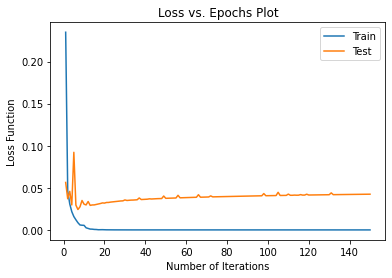

In [ ]:
loss_plot(train_loss_record, test_loss_record)

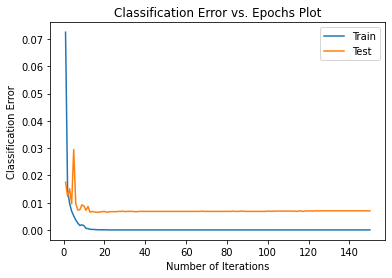

In [ ]:
error_plot(train_loss_record, test_loss_record)

## 4.(c)

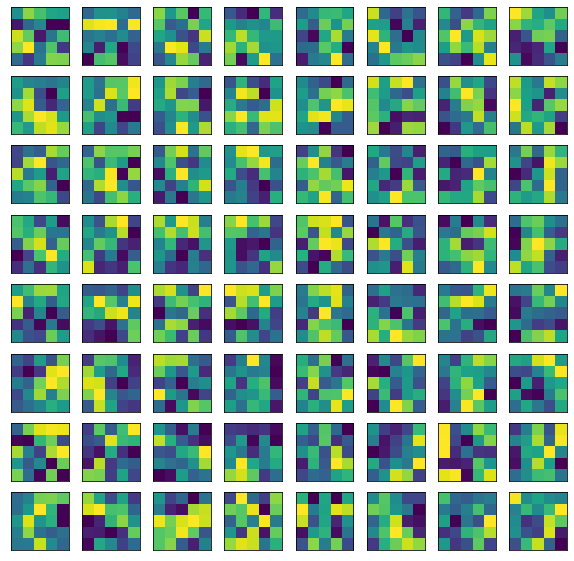

In [ ]:
weights = CNN1.state_dict()['cv1.weight']
plt.figure(figsize = (10,10))
for i in range(len(weights)):
  plt.subplot(8,8,i+1)
  plt.imshow(weights[i].reshape(5,5))
  plt.xticks([]) 
  plt.yticks([])

## 4.(d)

### Learning Rate = 0.01

In [ ]:
# Define HyperParameters
num_classes = 10
learning_rate = 0.01 
batch_size = 64
num_epochs = 150
CNN_LR01 = CNN(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_LR01.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,CNN_LR01,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,CNN_LR01,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.9147390956322352
Training accuracy: 0.7185833333333334
Testing loss: 0.2223067750833976
Testing accuracy: 0.9322
Epoch 2
-------------------------------
Training loss: 0.16861830121278762
Training accuracy: 0.9472833333333334
Testing loss: 0.15890299277320788
Testing accuracy: 0.9471
Epoch 3
-------------------------------
Training loss: 0.11189363651573658
Training accuracy: 0.9654
Testing loss: 0.094345892844781
Testing accuracy: 0.9705
Epoch 4
-------------------------------
Training loss: 0.08813865966747204
Training accuracy: 0.9731333333333333
Testing loss: 0.07058608751213119
Testing accuracy: 0.9775
Epoch 5
-------------------------------
Training loss: 0.07220804946323235
Training accuracy: 0.9770833333333333
Testing loss: 0.14196179600752842
Testing accuracy: 0.9509
Epoch 6
-------------------------------
Training loss: 0.061073552124698956
Training accuracy: 0.9811666666666666
Testing loss: 0.06316689352332881
Testing 

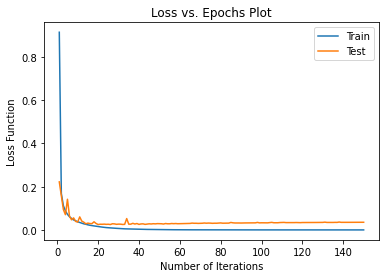

In [ ]:
loss_plot(train_loss_record, test_loss_record)

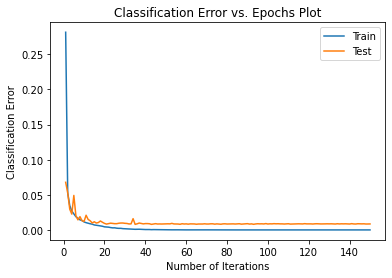

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Learning Rate = 0.2

In [ ]:
# Define HyperParameters
num_classes = 10
learning_rate = 0.2
batch_size = 64
num_epochs = 150
CNN_LR2 = CNN(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_LR2.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,CNN_LR2,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,CNN_LR2,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.2089302817231665
Training accuracy: 0.9349333333333333
Testing loss: 0.04776030449585242
Testing accuracy: 0.985
Epoch 2
-------------------------------
Training loss: 0.041457102549045034
Training accuracy: 0.98695
Testing loss: 0.030822439185213178
Testing accuracy: 0.991
Epoch 3
-------------------------------
Training loss: 0.026506554342464853
Training accuracy: 0.9916166666666667
Testing loss: 0.06431465027342212
Testing accuracy: 0.9798
Epoch 4
-------------------------------
Training loss: 0.01860000006131595
Training accuracy: 0.99405
Testing loss: 0.034020055487220306
Testing accuracy: 0.9894
Epoch 5
-------------------------------
Training loss: 0.013268378283649993
Training accuracy: 0.99575
Testing loss: 0.1342589622293006
Testing accuracy: 0.9672
Epoch 6
-------------------------------
Training loss: 0.011221977371177734
Training accuracy: 0.9962666666666666
Testing loss: 0.04131159391648919
Testing accuracy: 0.9892

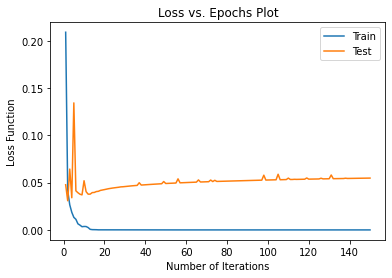

In [ ]:
loss_plot(train_loss_record, test_loss_record)

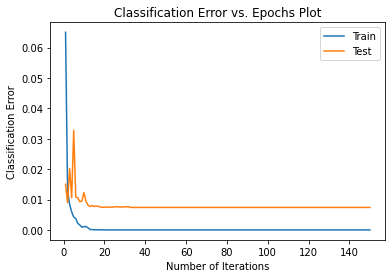

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Learning Rate = 0.5

In [ ]:
# Define HyperParameters
num_classes = 10
learning_rate = 0.5
batch_size = 64
num_epochs = 150
CNN_LR5 = CNN(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_LR5.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,CNN_LR5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,CNN_LR5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 2.2977896980285646
Training accuracy: 0.11411666666666667
Testing loss: 2.301359038444082
Testing accuracy: 0.1135
Epoch 2
-------------------------------
Training loss: 2.3030576077779132
Training accuracy: 0.10805
Testing loss: 2.3053683703112755
Testing accuracy: 0.1028
Epoch 3
-------------------------------
Training loss: 2.3029731824239095
Training accuracy: 0.10966666666666666
Testing loss: 2.302881722237654
Testing accuracy: 0.1032
Epoch 4
-------------------------------
Training loss: 2.3030292484283446
Training accuracy: 0.10638333333333333
Testing loss: 2.301590334837604
Testing accuracy: 0.1135
Epoch 5
-------------------------------
Training loss: 2.302662353515625
Training accuracy: 0.10756666666666667
Testing loss: 2.303895078646909
Testing accuracy: 0.1028
Epoch 6
-------------------------------
Training loss: 2.3030753377278645
Training accuracy: 0.10811666666666667
Testing loss: 2.3030293823047807
Testing accuracy

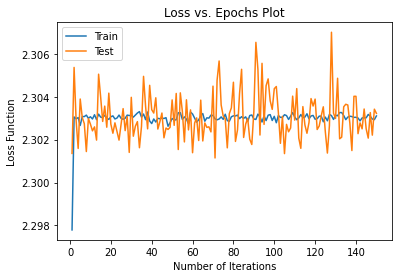

In [ ]:
loss_plot(train_loss_record, test_loss_record)

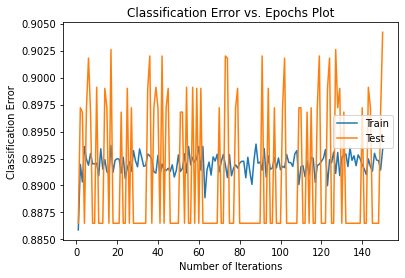

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Momentum = 0.5

In [ ]:
# Define HyperParameters
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.5
CNN_M5 = CNN(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_M5.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,CNN_M5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,CNN_M5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.180715152340134
Training accuracy: 0.9433666666666667
Testing loss: 0.04683813768450859
Testing accuracy: 0.9849
Epoch 2
-------------------------------
Training loss: 0.042554442864377054
Training accuracy: 0.98725
Testing loss: 0.03202736334227156
Testing accuracy: 0.9898
Epoch 3
-------------------------------
Training loss: 0.028105365255490566
Training accuracy: 0.9913
Testing loss: 0.04125671813436517
Testing accuracy: 0.9875
Epoch 4
-------------------------------
Training loss: 0.019487615456276884
Training accuracy: 0.9938666666666667
Testing loss: 0.03095214008865285
Testing accuracy: 0.9898
Epoch 5
-------------------------------
Training loss: 0.013805045191047248
Training accuracy: 0.9955166666666667
Testing loss: 0.04373322473973322
Testing accuracy: 0.9871
Epoch 6
-------------------------------
Training loss: 0.012323121504830973
Training accuracy: 0.9961833333333333
Testing loss: 0.04019418065197051
Testing accur

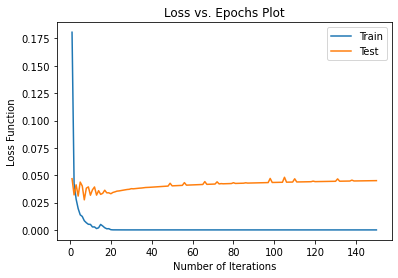

In [ ]:
loss_plot(train_loss_record, test_loss_record)

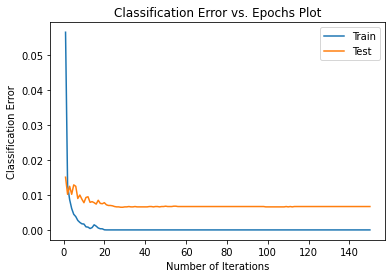

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Momentum = 0.9

In [ ]:
# Define HyperParameters
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.9
CNN_M9 = CNN(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_M9.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,CNN_M9,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,CNN_M9,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.20817018909572313
Training accuracy: 0.9414333333333333
Testing loss: 0.1289030188882937
Testing accuracy: 0.9677
Epoch 2
-------------------------------
Training loss: 0.08631866215982785
Training accuracy: 0.9771666666666666
Testing loss: 0.07061145777651331
Testing accuracy: 0.9823
Epoch 3
-------------------------------
Training loss: 0.07611314592754158
Training accuracy: 0.9805833333333334
Testing loss: 0.08315154938561142
Testing accuracy: 0.9788
Epoch 4
-------------------------------
Training loss: 0.07339582383890325
Training accuracy: 0.9820833333333333
Testing loss: 0.07707149930488152
Testing accuracy: 0.98
Epoch 5
-------------------------------
Training loss: 0.05222453261972793
Training accuracy: 0.9858666666666667
Testing loss: 0.06808744737905136
Testing accuracy: 0.9829
Epoch 6
-------------------------------
Training loss: 0.08474098649344718
Training accuracy: 0.9802166666666666
Testing loss: 0.13058465796190

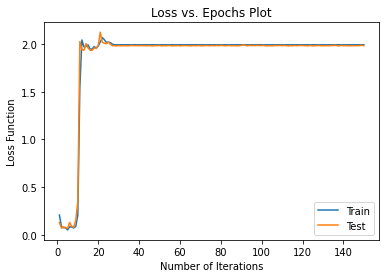

In [ ]:
loss_plot(train_loss_record, test_loss_record)

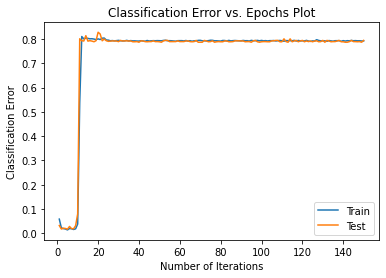

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Best Combination of Hyperparameters

Testing Accuracy As Follow:  
Learning Rate = 0.1: 99.3%;  
Learning Rate = 0.01: 99.15%;  
Learning Rate = 0.2: 99.26%;  
Learning Rate = 0.5: 9.58%;  
Momentum = 0.5 & Learning Rate = 0.1: 99.33%;  
Momentum = 0.9 & Learning Rate = 0.1: 2.06%.  


From above, we can see that models with learning rate = 0.2 or 0.1 suffer from the problem of overfitting. The model with learning rate = 0.5 and model with momentum = 0.9 cannot reach to local minumin. Therefore, we can conclude that learning rate = 0.1 & momentum = 0.5 is the best hyperparameters choice in terms of efficiency and accuracy.

## 5.(a) & (b)

In [ ]:
# Data Type Convert
transform = transforms.Compose(
    [transforms.Resize((32,32)), # Resize image to 32 * 32 to fit LeNet-5
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Read Data
train_data = MNIST(root='../data/mnist/', train=True, download=True, transform = transform)

test_data = MNIST(root='../data/ mnist/', train=False, download=True, transform = transform)

In [ ]:
# Create a LeNet-5
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear1 = nn.Linear(400, 120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84, num_classes)
   
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### Seed 1

In [ ]:
# Define HyperParameters
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
lenet1 = LeNet5(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet1.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,lenet1,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,lenet1,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.19397162635475398
Training accuracy: 0.94175
Testing loss: 0.058634764790701066
Testing accuracy: 0.9826
Epoch 2
-------------------------------
Training loss: 0.05534263921951254
Training accuracy: 0.9827
Testing loss: 0.04509820124122557
Testing accuracy: 0.9848
Epoch 3
-------------------------------
Training loss: 0.0414981879664585
Training accuracy: 0.9869
Testing loss: 0.04919673209404869
Testing accuracy: 0.9845
Epoch 4
-------------------------------
Training loss: 0.03239848137460649
Training accuracy: 0.9898666666666667
Testing loss: 0.03407000073018205
Testing accuracy: 0.9885
Epoch 5
-------------------------------
Training loss: 0.026397477308226128
Training accuracy: 0.9915166666666667
Testing loss: 0.07600413198852733
Testing accuracy: 0.9738
Epoch 6
-------------------------------
Training loss: 0.022175171821129817
Training accuracy: 0.9931166666666666
Testing loss: 0.028007456362484747
Testing accuracy: 0.9903


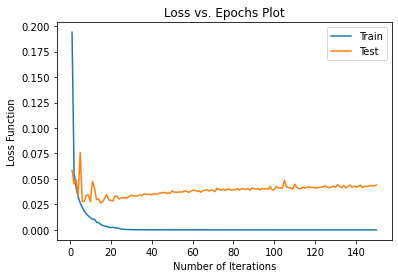

In [ ]:
loss_plot(train_loss_record, test_loss_record)

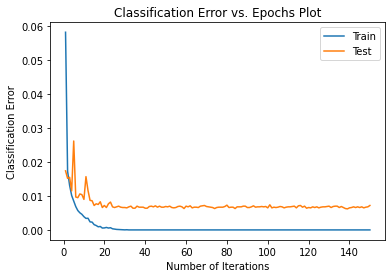

In [ ]:
error_plot(train_loss_record, test_loss_record)

## 5.(c)

In [ ]:
# Check The Shape of Weights for the first Convolutional Layer
lenet1.state_dict()['conv1.0.weight'].shape

torch.Size([6, 1, 5, 5])

There are 6 filters for the first Convolutional Layer, which is corresponding to the number of output channel.
The dimension for each filter is 5 * 5.

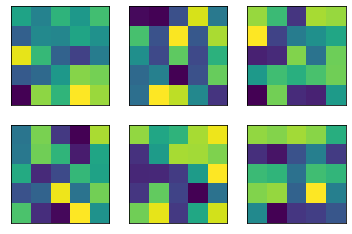

In [ ]:
weights = lenet1.state_dict()['conv1.0.weight']
for i in range(len(weights)):
  plt.subplot(2,3,i+1)
  plt.imshow(weights[i].reshape(5,5))
  plt.xticks([]) 
  plt.yticks([])

## 5.(d)

### Learning Rate = 0.01

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.01 
batch_size = 64
num_epochs = 150
lenet_lr01 = LeNet5(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_lr01.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,lenet_lr01,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,lenet_lr01,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.6853841362794241
Training accuracy: 0.8327166666666667
Testing loss: 0.1440351867609343
Testing accuracy: 0.9612
Epoch 2
-------------------------------
Training loss: 0.124516569540898
Training accuracy: 0.9641166666666666
Testing loss: 0.08905586863684047
Testing accuracy: 0.9726
Epoch 3
-------------------------------
Training loss: 0.08921225286821524
Training accuracy: 0.9738333333333333
Testing loss: 0.07716064344925486
Testing accuracy: 0.9775
Epoch 4
-------------------------------
Training loss: 0.0727513346195221
Training accuracy: 0.9788833333333333
Testing loss: 0.05842110099698043
Testing accuracy: 0.9813
Epoch 5
-------------------------------
Training loss: 0.062294406992197036
Training accuracy: 0.9814333333333334
Testing loss: 0.058281122677170547
Testing accuracy: 0.9816
Epoch 6
-------------------------------
Training loss: 0.055664934312055506
Training accuracy: 0.9834333333333334
Testing loss: 0.0496902860238

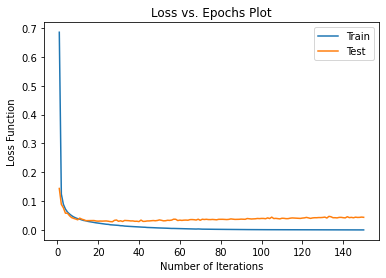

In [ ]:
loss_plot(train_loss_record, test_loss_record)

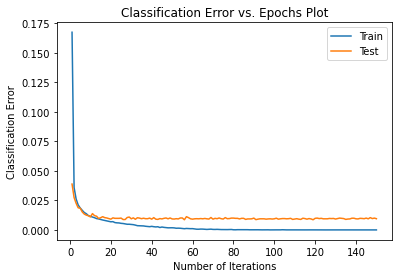

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Learning Rate = 0.2

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.2
batch_size = 64
num_epochs = 150
lenet_lr2 = LeNet5(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_lr2.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,lenet_lr2,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,lenet_lr2,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.1814465950275461
Training accuracy: 0.9436
Testing loss: 0.06795152381898918
Testing accuracy: 0.9781
Epoch 2
-------------------------------
Training loss: 0.04988939085776607
Training accuracy: 0.9843166666666666
Testing loss: 0.03892700129023984
Testing accuracy: 0.9879
Epoch 3
-------------------------------
Training loss: 0.03657733850255609
Training accuracy: 0.98865
Testing loss: 0.033855288078160184
Testing accuracy: 0.9891
Epoch 4
-------------------------------
Training loss: 0.026789985394943507
Training accuracy: 0.99165
Testing loss: 0.030583737193010628
Testing accuracy: 0.9901
Epoch 5
-------------------------------
Training loss: 0.022650966536051906
Training accuracy: 0.9928
Testing loss: 0.08107857554142547
Testing accuracy: 0.9731
Epoch 6
-------------------------------
Training loss: 0.019456638929480685
Training accuracy: 0.99385
Testing loss: 0.028167668684603717
Testing accuracy: 0.9905
Epoch 7
------------

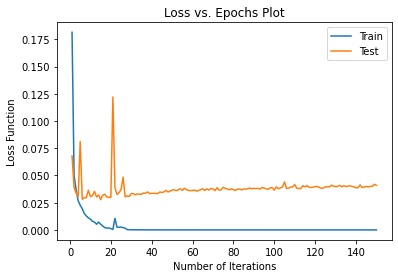

In [ ]:
loss_plot(train_loss_record, test_loss_record)

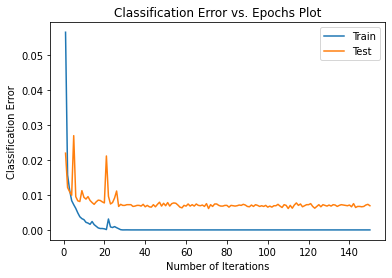

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Learning Rate = 0.5

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.5
batch_size = 64
num_epochs = 150
lenet_lr5 = LeNet5(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_lr5.parameters(), lr = learning_rate)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,lenet_lr5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,lenet_lr5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.21703040427838763
Training accuracy: 0.9325
Testing loss: 0.06896933227937645
Testing accuracy: 0.9799
Epoch 2
-------------------------------
Training loss: 0.055042807489757734
Training accuracy: 0.9832833333333333
Testing loss: 0.05495754222587273
Testing accuracy: 0.9834
Epoch 3
-------------------------------
Training loss: 0.04120508547729502
Training accuracy: 0.98745
Testing loss: 0.07400287756886167
Testing accuracy: 0.9774
Epoch 4
-------------------------------
Training loss: 0.0316856589142854
Training accuracy: 0.99005
Testing loss: 0.042369604229357594
Testing accuracy: 0.9877
Epoch 5
-------------------------------
Training loss: 0.02660630459910414
Training accuracy: 0.9916833333333334
Testing loss: 0.07389882639507248
Testing accuracy: 0.9784
Epoch 6
-------------------------------
Training loss: 0.023085295110878847
Training accuracy: 0.99285
Testing loss: 0.03407763715977647
Testing accuracy: 0.9891
Epoch 7
---

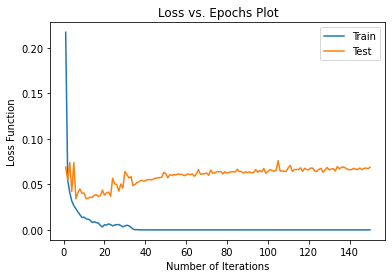

In [ ]:
loss_plot(train_loss_record, test_loss_record)

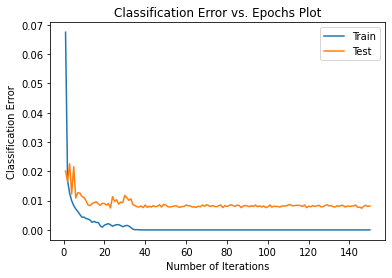

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Momentum = 0.5

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.5
lenet_m5 = LeNet5(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_m5.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,lenet_m5,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,lenet_m5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.14802460279762744
Training accuracy: 0.9540833333333333
Testing loss: 0.07082441506112457
Testing accuracy: 0.9775
Epoch 2
-------------------------------
Training loss: 0.049307311786711217
Training accuracy: 0.9846166666666667
Testing loss: 0.03900724802511762
Testing accuracy: 0.9869
Epoch 3
-------------------------------
Training loss: 0.035793078905840714
Training accuracy: 0.9888166666666667
Testing loss: 0.035257294713994074
Testing accuracy: 0.9882
Epoch 4
-------------------------------
Training loss: 0.027371712402192255
Training accuracy: 0.9912833333333333
Testing loss: 0.03188755950882325
Testing accuracy: 0.99
Epoch 5
-------------------------------
Training loss: 0.021755737696168943
Training accuracy: 0.9933
Testing loss: 0.042698904627060615
Testing accuracy: 0.9862
Epoch 6
-------------------------------
Training loss: 0.018178562711598352
Training accuracy: 0.99395
Testing loss: 0.029803083038827328
Testing ac

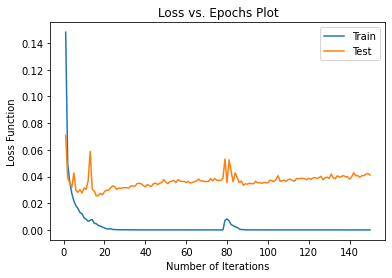

In [ ]:
loss_plot(train_loss_record, test_loss_record)

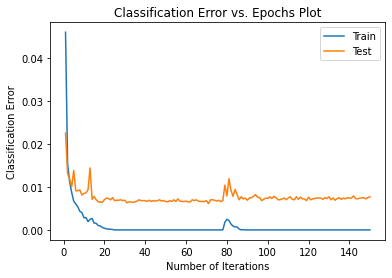

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Momentum = 0.9

In [ ]:
# Define HyperParameters
input_size = 784
num_classes = 10
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.9
lenet_m9 = LeNet5(num_classes)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_m9.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
# Set Seed
torch.manual_seed(1) 

# Data Loading
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)



start_time = time.time()
test_loss_record = []
train_loss_record =[]
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop(train_loader,lenet_m9,loss,optimizer))
    test_loss_record.append(test_loop(test_loader,lenet_m9,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 0.17066763468831778
Training accuracy: 0.9496
Testing loss: 0.045336998713270994
Testing accuracy: 0.9869
Epoch 2
-------------------------------
Training loss: 0.061761704346304756
Training accuracy: 0.9827
Testing loss: 0.03981207929396628
Testing accuracy: 0.9888
Epoch 3
-------------------------------
Training loss: 0.051439117785325894
Training accuracy: 0.9856
Testing loss: 0.03529274272476619
Testing accuracy: 0.9897
Epoch 4
-------------------------------
Training loss: 0.03837745738786956
Training accuracy: 0.9891166666666666
Testing loss: 0.04577708432738592
Testing accuracy: 0.9862
Epoch 5
-------------------------------
Training loss: 0.034237265561070915
Training accuracy: 0.9902
Testing loss: 0.04323852910103805
Testing accuracy: 0.9886
Epoch 6
-------------------------------
Training loss: 0.027768395057091645
Training accuracy: 0.9922
Testing loss: 0.056058517946474436
Testing accuracy: 0.986
Epoch 7
---------------

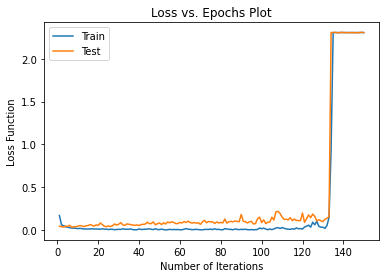

In [ ]:
loss_plot(train_loss_record, test_loss_record)

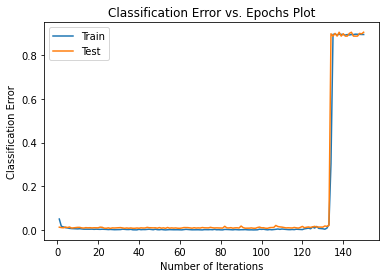

In [ ]:
error_plot(train_loss_record, test_loss_record)

### Best Combination of Hyperparameters

Testing Accuracy As follow:  
Learning Rate = 0.1: 99.28%;  
Learning Rate = 0.01: 99.05%;  
Learning Rate = 0.2: 99.31%;  
Learning Rate = 0.5: 99.18%;  
Momentum = 0.5 & Learning Rate = 0.1: 99.23%;  
Momentum = 0.9 & Learning Rate = 0.1: 9.58%.  

From above, it can be observed that the loss function of LeNet5 can always converge quickly to local minimum with different hyperparameters. However, all models suffer from the problem of overfitting, while for the models with learning rate = 0.2, learning rate = 0.5 and momentum = 0.5, we can observe a sudden surge in loss and misclassification error, which indicates loss function moves away from local minimum. In, addition, it can be observed that the model with momentum = 0.9 moves away from local minimum and cannot return to local minimum. Therefore, we can conclude that momentum is unnecessary for LeNet5 and a small learning rate like 0.1 and 0.01 is good enough.

# V. More about Deep Learning

## 6.

In [ ]:
# Load Data
train_data = pd.read_csv('/train.txt', header = None)
test_data = pd.read_csv('/test.txt', header = None)
val_data = pd.read_csv('/val.txt', header = None)

In [ ]:
train_data.shape

(20000, 1569)

<font size="3">From above, we can see that the number of rows is 20000. We know that each sample is composed of a total of 1568 pixels and one label. Therfore, we know that the pixels are scanned out in row-major order. </font>

In [ ]:
# Define a Function to plot Sample and Return Labels
def sampleplot(index):
    x = train_data.loc[index][:-1]
    y = train_data.loc[index][-1:]
    x = np.array(x).reshape(28,56)
    imshow(x)
    print(y)

1568    12.0
Name: 4, dtype: float64


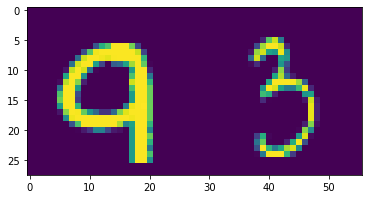

In [ ]:
sampleplot(4)

1568    15.0
Name: 5, dtype: float64


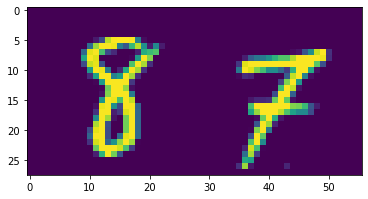

In [ ]:
sampleplot(5)

1568    9.0
Name: 6, dtype: float64


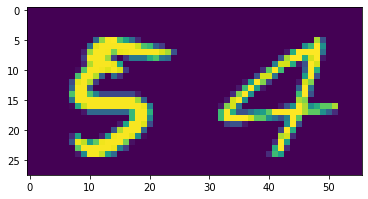

In [ ]:
sampleplot(6)

<font size="3"> From above, we can see that the sum of two digits equal to the last coordinate of each line. </font>

## 7.(a)

In [ ]:
# Data Process
Y_train = np.array(train_data[1568])
Y_train = torch.from_numpy(Y_train).double()
X_train = np.array(train_data[train_data.columns[0:1568]]).reshape(20000,1,28,56)
X_train = torch.from_numpy(X_train).double()


# Test Data
Y_test = np.array(test_data[1568])
Y_test = torch.from_numpy(Y_test).double()
X_test = np.array(test_data[test_data.columns[0:1568]]).reshape(5000,1,28,56)
X_test = torch.from_numpy(X_test).double()


# Validation Data
Y_val = np.array(val_data[1568])
Y_val = torch.from_numpy(Y_val).double()
X_val = np.array(val_data[val_data.columns[0:1568]]).reshape(5000,1,28,56)
X_val = torch.from_numpy(X_val).double()



In [ ]:
# Define Required Plot Function
def loss_plot1(train,test,val):
    index = []
    train_set = []
    test_set = []
    val_set = []
    for i in range(len(train)):
        index.append(i+1)
        train_set.append(train[i][0])
        test_set.append(test[i][0])
        val_set.append(val[i][0])
    plt.plot(index, train_set, label = "Train")
    plt.plot(index, test_set, label = "Test")
    plt.plot(index, val_set, label = "Validation")
    plt.legend()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss Function")
    plt.title("Loss vs. Epochs Plot")
    
def error_plot1(train,test,val):
    index = []
    train_set = []
    test_set = []
    val_set = []
    for i in range(len(train)):
        index.append(i+1)
        train_set.append(1 - train[i][1])
        test_set.append(1 - test[i][1])
        val_set.append(1 - val[i][1])
    plt.plot(index, train_set, label = "Train")
    plt.plot(index, test_set, label = "Test")
    plt.plot(index, val_set, label = "Validation")
    plt.legend()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Classification Error")
    plt.title("Classification Error vs. Epochs Plot")

In [ ]:
def train_loop7(feature,label, model, loss_fn, optimizer):
    running_loss, correct = 0, 0
    size = len(feature)
    for index, X in enumerate(feature):
        # Compute prediction and loss
        y = label[index]
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item()
        correct += (torch.round(pred) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss = running_loss / size
    correct /= size
    print('Training loss: {}'.format(running_loss)) 
    print('Training accuracy: {}'.format(correct))
    return running_loss, correct


def test_loop7(feature,label, model, loss_fn):
    size = len(feature)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for index, X in enumerate(feature):
            pred = model(X)
            y = label[index]
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print('Testing loss: {}'.format(test_loss))
    print('Testing accuracy: {}'.format(correct))
    return test_loss, correct

## Replication From Paper 

In [ ]:
class sum_model(nn.Module):
    def __init__(self):
        super(sum_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # Output Shape 26 * 54 * 32
        self.conv2 = nn.Conv2d(32, 16, 3) # Output Shape 24 * 52 * 16
        self.pool1 = nn.MaxPool2d(2) # Output Shape 12 * 26 * 16 
        self.do = nn.Dropout(0.25) 
        self.flatten = nn.Flatten() # Output Shpae 16 * 312
        self.linear1 = nn.Linear(312, 16) # ouput shape 16 * 16
        self.do2 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(256, 100)
        self.linear3 = nn.Linear(100, 1) # Output Shape 1 Make it Regression
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.do(x)
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = x.reshape(-1)
        x = self.do2(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        
        return x

### Learning Rate = 1

In [ ]:
# Define HyperParameters
learning_rate = 1
batch_size = 64
num_epochs = 150


net5 = sum_model().double()
# Use the same optimizer Adadelta As in the paper
optimizer = optim.Adadelta(net5.parameters(), lr = learning_rate, rho = 0.95, eps = 1e-08, weight_decay = 0)
# Mean Squared Error Loss Function Used
loss = nn.MSELoss()

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(X_train,Y_train,net5,loss,optimizer))
    test_loss_record.append(test_loop7(X_test,Y_test,net5,loss))
    val_loss_record.append(test_loop7(X_val,Y_val,net5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 8.733014670041598
Training accuracy: 0.13515
Testing loss: 6.713187465276153
Testing accuracy: 0.161
Testing loss: 6.954100303243907
Testing accuracy: 0.1488
Epoch 2
-------------------------------
Training loss: 5.787012530651331
Training accuracy: 0.1701
Testing loss: 5.507572200596529
Testing accuracy: 0.1898
Testing loss: 5.803358649226282
Testing accuracy: 0.1714
Epoch 3
-------------------------------
Training loss: 4.941862898710696
Training accuracy: 0.196
Testing loss: 5.249234976399224
Testing accuracy: 0.193
Testing loss: 5.39511510594798
Testing accuracy: 0.1912
Epoch 4
-------------------------------
Training loss: 4.488168319734062
Training accuracy: 0.20445
Testing loss: 4.923821420960263
Testing accuracy: 0.2008
Testing loss: 5.20127244488753
Testing accuracy: 0.2046
Epoch 5
-------------------------------
Training loss: 4.12407235509744
Training accuracy: 0.21025
Testing loss: 4.102558243606319
Testing accuracy: 0.227
Testing loss: 4.311140112294585
Test

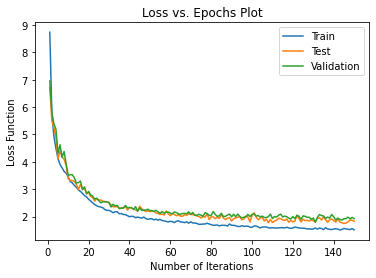

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

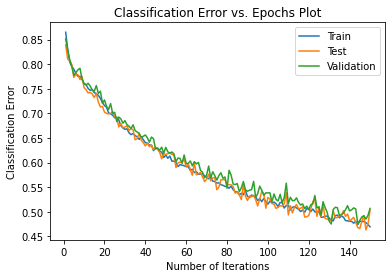

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Weight Visualization

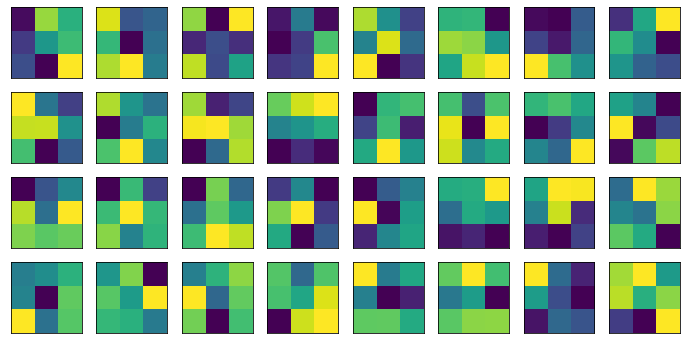

In [ ]:
# Visualize the Weights from First Convolutional Network
weights = net5.state_dict()['conv1.weight']
plt.figure(figsize = (12,6))
for i in range(len(weights)):
  plt.subplot(4,8,i+1)
  plt.imshow(weights[i].reshape(3,3))
  plt.xticks([]) 
  plt.yticks([])

### Learning Rate = 0.2

In [ ]:
# Define HyperParameters
learning_rate = 0.2
batch_size = 64
num_epochs = 150


sum_2 = sum_model().double()
optimizer = optim.Adadelta(sum_2.parameters(), lr = learning_rate, rho = 0.95, eps = 1e-08, weight_decay = 0)
loss = nn.MSELoss()

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(X_train,Y_train,sum_2,loss,optimizer))
    test_loss_record.append(test_loop7(X_test,Y_test,sum_2,loss))
    val_loss_record.append(test_loop7(X_val,Y_val,sum_2,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 14.068749374372768
Training accuracy: 0.10765
Testing loss: 9.069129284031499
Testing accuracy: 0.1274
Testing loss: 9.965047183380833
Testing accuracy: 0.1206
Epoch 2
-------------------------------
Training loss: 8.54878400986955
Training accuracy: 0.13115
Testing loss: 7.006364061664567
Testing accuracy: 0.1578
Testing loss: 7.754154883440524
Testing accuracy: 0.1396
Epoch 3
-------------------------------
Training loss: 7.0461437565447875
Training accuracy: 0.15045
Testing loss: 6.26751159580526
Testing accuracy: 0.1666
Testing loss: 6.690881291604672
Testing accuracy: 0.1608
Epoch 4
-------------------------------
Training loss: 6.424408579399578
Training accuracy: 0.1526
Testing loss: 6.13325766736777
Testing accuracy: 0.1698
Testing loss: 6.61760538827953
Testing accuracy: 0.1624
Epoch 5
-------------------------------
Training loss: 6.0469635856184105
Training accuracy: 0.16745
Testing loss: 5.8483203989804045
Testing accuracy: 0.1766
Testing loss: 6.271647489672

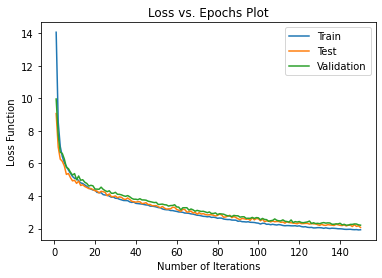

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

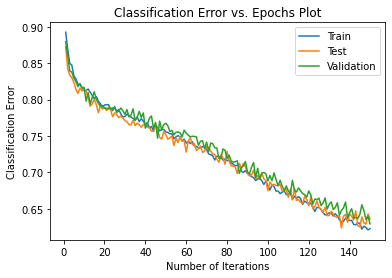

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Learning Rate = 2.5

In [ ]:
# Define HyperParameters
learning_rate = 2.5
batch_size = 64
num_epochs = 150


sum_5 = sum_model().double()
optimizer = optim.Adadelta(sum_5.parameters(), lr = learning_rate, rho = 0.95, eps = 1e-08, weight_decay = 0)
loss = nn.MSELoss()

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(X_train,Y_train,sum_5,loss,optimizer))
    test_loss_record.append(test_loop7(X_test,Y_test,sum_5,loss))
    val_loss_record.append(test_loop7(X_val,Y_val,sum_5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 7.914323465178954
Training accuracy: 0.1461
Testing loss: 6.277155181921705
Testing accuracy: 0.1662
Testing loss: 6.528202233510359
Testing accuracy: 0.1542
Epoch 2
-------------------------------
Training loss: 5.170067478299104
Training accuracy: 0.1853
Testing loss: 5.501395778148721
Testing accuracy: 0.1794
Testing loss: 5.6094114807468225
Testing accuracy: 0.1782
Epoch 3
-------------------------------
Training loss: 4.520066956337345
Training accuracy: 0.19965
Testing loss: 4.345092121105099
Testing accuracy: 0.209
Testing loss: 4.594819986177789
Testing accuracy: 0.2002
Epoch 4
-------------------------------
Training loss: 4.110619675028517
Training accuracy: 0.2126
Testing loss: 4.527076538301302
Testing accuracy: 0.2032
Testing loss: 4.7689084050972035
Testing accuracy: 0.2044
Epoch 5
-------------------------------
Training loss: 3.820491174327876
Training accuracy: 0.2202
Testing loss: 4.240535512814301
Testing accuracy: 0.2136
Testing loss: 4.47046011421292

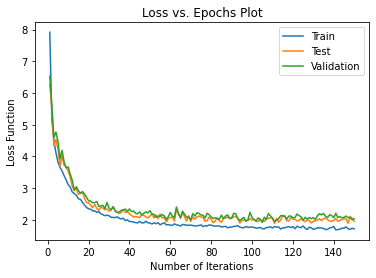

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

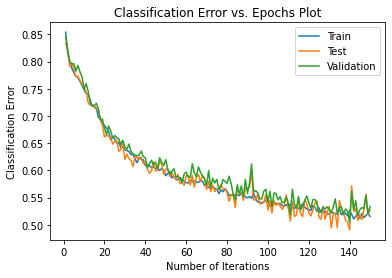

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

From above, we can observe the validation error as follow:  
Learning Rate = 1: 50.66%;  
Learning Rate = 0.2: 62.94%;  
Learning Rate = 2.5: 53.34%.  
Therefore, we choose the model with learning rate = 1. In addition, it can be observed that the loss function and misclassification keep decreasing with the number of epochs increasing. In another word, they do not suffer from the problem of overfitting and we can increase the number of epochs to obtain better result. However, due to the limited calculation power of my computer, I decide not to do it.  
The testing error of our chosen model is 50.26% which is significantly larger than the test errors with respect to the original MNIST data. The bad performance is probably because I decrease the number of output channels of the second convolutional layer due to the limited calculation power of my computer. However, we can see that this algorithm replicated from paper is generalizable. Therefore, I believe we can train a good enough model with a better computer. 

## 3-Layer 2D Convolutional Neural Network

In [ ]:
def train_loop7(feature,label, model, loss_fn, optimizer):
    running_loss, correct = 0, 0
    size = len(feature.dataset)
    label = iter(label)
    for index, X in enumerate(feature):
        # Compute prediction and loss
        y = next(label)
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss = running_loss / size
    correct /= size
    print('Training loss: {}'.format(running_loss)) 
    print('Training accuracy: {}'.format(correct))
    return running_loss, correct


def test_loop7(feature,label, model, loss_fn):
    size = len(feature.dataset)
    test_loss, correct = 0, 0
    label = iter(label)
    with torch.no_grad():
        for index, X in enumerate(feature):
            pred = model(X)
            y = next(label)
            test_loss += loss_fn(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print('Testing loss: {}'.format(test_loss))
    print('Testing accuracy: {}'.format(correct))
    return test_loss, correct

In [ ]:
# Create a Convolutional Neural Network
class CNN1(nn.Module):
    def __init__(self, num_classes):
        super(CNN1, self).__init__() # Input Shape 1 * 28 * 56
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        ) # Ouput Shape 32 * 13 * 27
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ) # Output Shape 64 * 5 * 12
        self.conv3 = nn.Conv2d(64,128,3) # Output Shape 128 * 3 * 10
        self.fc1 = nn.Linear(3840, 800) # Output Shape 800
        self.fc2 = nn.Linear(800, 256) # Output Shape 256
        self.fc3 = nn.Linear(256, num_classes) # Output Shape: num_classes
   
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 3840)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Learning Rate = 0.1

In [ ]:
# Define HyperParameters
# Number of Classes = 19
num_classes = 19
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
CNN_1 = CNN1(num_classes).double()

# Batch Datat
train_loader = DataLoader(X_train, batch_size = batch_size)
train_loader_y = DataLoader(Y_train.type(torch.LongTensor), batch_size = batch_size)
test_loader = DataLoader(X_test, batch_size = batch_size)
test_loader_y = DataLoader(Y_test.type(torch.LongTensor), batch_size = batch_size)
val_loader = DataLoader(X_val, batch_size = batch_size)
val_loader_y = DataLoader(Y_val.type(torch.LongTensor), batch_size = batch_size)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_1.parameters(), lr = learning_rate)

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(train_loader,train_loader_y,CNN_1,loss,optimizer))
    test_loss_record.append(test_loop7(test_loader,test_loader_y,CNN_1,loss))
    val_loss_record.append(test_loop7(val_loader,val_loader_y,CNN_1,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 2.222648693893431
Training accuracy: 0.23815
Testing loss: 1.2898517817829631
Testing accuracy: 0.572
Testing loss: 1.339690626509763
Testing accuracy: 0.5468
Epoch 2
-------------------------------
Training loss: 0.5660560619469733
Training accuracy: 0.825
Testing loss: 0.26429943028546293
Testing accuracy: 0.9214
Testing loss: 0.30331065234062976
Testing accuracy: 0.9134
Epoch 3
-------------------------------
Training loss: 0.19262644205312182
Training accuracy: 0.9427
Testing loss: 0.18791878109869548
Testing accuracy: 0.9396
Testing loss: 0.21953821264595227
Testing accuracy: 0.9382
Epoch 4
-------------------------------
Training loss: 0.09648740228151817
Training accuracy: 0.9713
Testing loss: 0.15263679436224498
Testing accuracy: 0.9548
Testing loss: 0.17970415721820523
Testing accuracy: 0.9528
Epoch 5
-------------------------------
Training loss: 0.04894115292633467
Training accuracy: 0.98585
Testing loss: 0.1442051474917

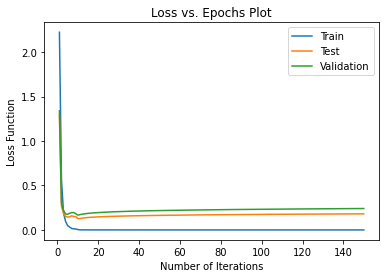

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

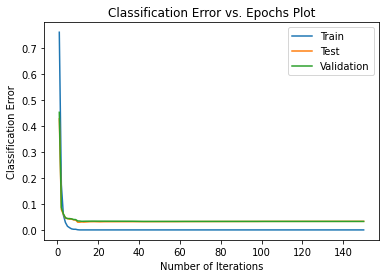

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Weight Visualization

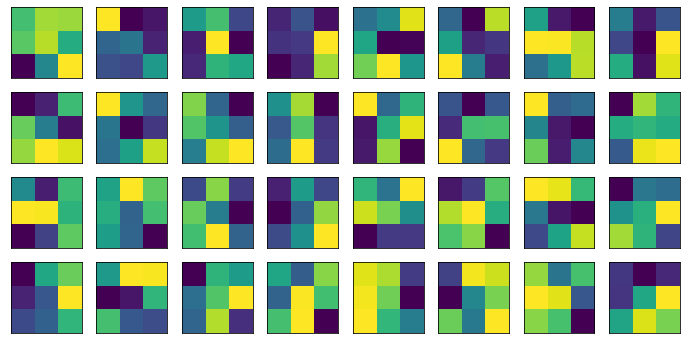

In [ ]:
# Visualize the Weights from First Convolutional Network
weights = CNN_1.state_dict()['conv1.0.weight']
plt.figure(figsize = (12,6))
for i in range(len(weights)):
  plt.subplot(4,8,i+1)
  plt.imshow(weights[i].reshape(3,3))
  plt.xticks([]) 
  plt.yticks([])

### Learning Rate = 0.01

In [ ]:
# Define HyperParameters
# Number of Classes = 19
num_classes = 19
learning_rate = 0.01
batch_size = 64
num_epochs = 150
CNN_01 = CNN1(num_classes).double()

# Batch Datat
train_loader = DataLoader(X_train, batch_size = batch_size)
train_loader_y = DataLoader(Y_train.type(torch.LongTensor), batch_size = batch_size)
test_loader = DataLoader(X_test, batch_size = batch_size)
test_loader_y = DataLoader(Y_test.type(torch.LongTensor), batch_size = batch_size)
val_loader = DataLoader(X_val, batch_size = batch_size)
val_loader_y = DataLoader(Y_val.type(torch.LongTensor), batch_size = batch_size)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_01.parameters(), lr = learning_rate)

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(train_loader,train_loader_y,CNN_01,loss,optimizer))
    test_loss_record.append(test_loop7(test_loader,test_loader_y,CNN_01,loss))
    val_loss_record.append(test_loop7(val_loader,val_loader_y,CNN_01,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 2.7982280463455926
Training accuracy: 0.09995
Testing loss: 2.7335573703380227
Testing accuracy: 0.1116
Testing loss: 2.7489105041816377
Testing accuracy: 0.107
Epoch 2
-------------------------------
Training loss: 2.5758855677806483
Training accuracy: 0.1417
Testing loss: 2.4465241470184353
Testing accuracy: 0.1588
Testing loss: 2.491755502874469
Testing accuracy: 0.1622
Epoch 3
-------------------------------
Training loss: 2.249406127977174
Training accuracy: 0.21405
Testing loss: 2.3892735420996565
Testing accuracy: 0.1738
Testing loss: 2.4584518453663726
Testing accuracy: 0.1696
Epoch 4
-------------------------------
Training loss: 2.020702189402078
Training accuracy: 0.2914
Testing loss: 2.1791260177381404
Testing accuracy: 0.265
Testing loss: 2.251808186132121
Testing accuracy: 0.2552
Epoch 5
-------------------------------
Training loss: 1.766477831813971
Training accuracy: 0.40355
Testing loss: 1.9449788301003217
Testing

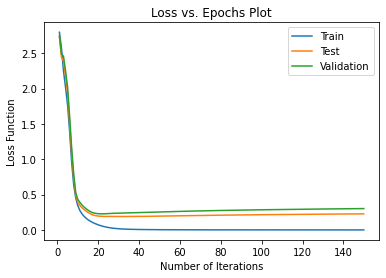

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

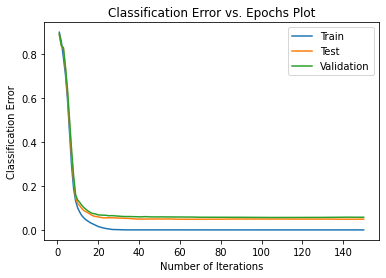

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Learning Rate = 0.2

In [ ]:
# Define HyperParameters
# Number of Classes = 19
num_classes = 19
learning_rate = 0.2
batch_size = 64
num_epochs = 150
CNN_2 = CNN1(num_classes).double()

# Batch Datat
train_loader = DataLoader(X_train, batch_size = batch_size)
train_loader_y = DataLoader(Y_train.type(torch.LongTensor), batch_size = batch_size)
test_loader = DataLoader(X_test, batch_size = batch_size)
test_loader_y = DataLoader(Y_test.type(torch.LongTensor), batch_size = batch_size)
val_loader = DataLoader(X_val, batch_size = batch_size)
val_loader_y = DataLoader(Y_val.type(torch.LongTensor), batch_size = batch_size)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_2.parameters(), lr = learning_rate)

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(train_loader,train_loader_y,CNN_2,loss,optimizer))
    test_loss_record.append(test_loop7(test_loader,test_loader_y,CNN_2,loss))
    val_loss_record.append(test_loop7(val_loader,val_loader_y,CNN_2,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 1.8819665749575714
Training accuracy: 0.3654
Testing loss: 0.5782961348441121
Testing accuracy: 0.8116
Testing loss: 0.6366700513225486
Testing accuracy: 0.7984
Epoch 2
-------------------------------
Training loss: 0.32953013694323774
Training accuracy: 0.90105
Testing loss: 0.29098236962545687
Testing accuracy: 0.9058
Testing loss: 0.3286487615404689
Testing accuracy: 0.9012
Epoch 3
-------------------------------
Training loss: 0.13560839501911331
Training accuracy: 0.9586
Testing loss: 0.1642162605374861
Testing accuracy: 0.9502
Testing loss: 0.18011320673266693
Testing accuracy: 0.9516
Epoch 4
-------------------------------
Training loss: 0.06745339581008951
Training accuracy: 0.9798
Testing loss: 0.15789127551528626
Testing accuracy: 0.9556
Testing loss: 0.18153376724237538
Testing accuracy: 0.9546
Epoch 5
-------------------------------
Training loss: 0.0451101654341834
Training accuracy: 0.98545
Testing loss: 0.15300025269

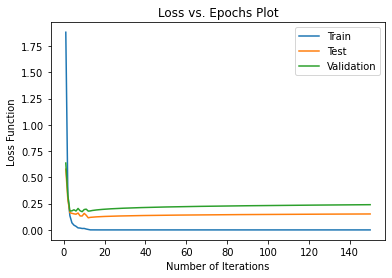

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

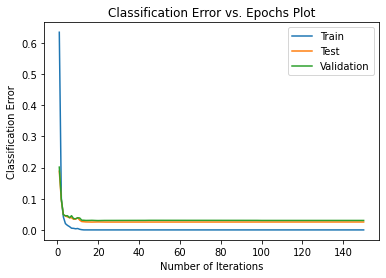

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Learning Rate = 0.5

In [ ]:
# Define HyperParameters
# Number of Classes = 19
num_classes = 19
learning_rate = 0.5
batch_size = 64
num_epochs = 150
CNN_5 = CNN1(num_classes).double()

# Batch Datat
train_loader = DataLoader(X_train, batch_size = batch_size)
train_loader_y = DataLoader(Y_train.type(torch.LongTensor), batch_size = batch_size)
test_loader = DataLoader(X_test, batch_size = batch_size)
test_loader_y = DataLoader(Y_test.type(torch.LongTensor), batch_size = batch_size)
val_loader = DataLoader(X_val, batch_size = batch_size)
val_loader_y = DataLoader(Y_val.type(torch.LongTensor), batch_size = batch_size)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_5.parameters(), lr = learning_rate)

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(train_loader,train_loader_y,CNN_5,loss,optimizer))
    test_loss_record.append(test_loop7(test_loader,test_loader_y,CNN_5,loss))
    val_loss_record.append(test_loop7(val_loader,val_loader_y,CNN_5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 2.2546351951514043
Training accuracy: 0.2434
Testing loss: 1.2123662931003962
Testing accuracy: 0.6684
Testing loss: 1.2616139588850737
Testing accuracy: 0.6478
Epoch 2
-------------------------------
Training loss: 0.5061800451384768
Training accuracy: 0.84755
Testing loss: 0.3094987507556903
Testing accuracy: 0.9068
Testing loss: 0.33035225385959643
Testing accuracy: 0.907
Epoch 3
-------------------------------
Training loss: 0.20505286249564675
Training accuracy: 0.9413
Testing loss: 0.23563692501858732
Testing accuracy: 0.937
Testing loss: 0.2631870177180386
Testing accuracy: 0.9348
Epoch 4
-------------------------------
Training loss: 0.12166823076685707
Training accuracy: 0.9629
Testing loss: 0.19931636035215214
Testing accuracy: 0.9458
Testing loss: 0.2280247592830067
Testing accuracy: 0.9458
Epoch 5
-------------------------------
Training loss: 0.08397028312935195
Training accuracy: 0.9743
Testing loss: 0.244208851996439

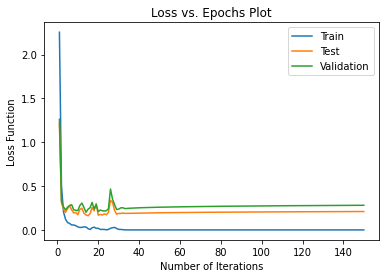

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

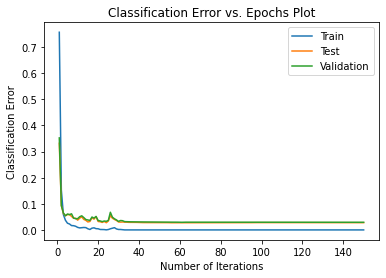

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Momentum = 0.5

In [ ]:
# Define HyperParameters
# Number of Classes = 19
num_classes = 19
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.5
CNN_M5 = CNN1(num_classes).double()

# Batch Datat
train_loader = DataLoader(X_train, batch_size = batch_size)
train_loader_y = DataLoader(Y_train.type(torch.LongTensor), batch_size = batch_size)
test_loader = DataLoader(X_test, batch_size = batch_size)
test_loader_y = DataLoader(Y_test.type(torch.LongTensor), batch_size = batch_size)
val_loader = DataLoader(X_val, batch_size = batch_size)
val_loader_y = DataLoader(Y_val.type(torch.LongTensor), batch_size = batch_size)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_M5.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(train_loader,train_loader_y,CNN_M5,loss,optimizer))
    test_loss_record.append(test_loop7(test_loader,test_loader_y,CNN_M5,loss))
    val_loss_record.append(test_loop7(val_loader,val_loader_y,CNN_M5,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 1.9095479911088613
Training accuracy: 0.3466
Testing loss: 0.6747865470522089
Testing accuracy: 0.7826
Testing loss: 0.7627325702547252
Testing accuracy: 0.7504
Epoch 2
-------------------------------
Training loss: 0.34702036163966293
Training accuracy: 0.89685
Testing loss: 0.22728402353172675
Testing accuracy: 0.9336
Testing loss: 0.2682058225116405
Testing accuracy: 0.9232
Epoch 3
-------------------------------
Training loss: 0.15095181281157213
Training accuracy: 0.9542
Testing loss: 0.17665663021880448
Testing accuracy: 0.9456
Testing loss: 0.21556594247722427
Testing accuracy: 0.9384
Epoch 4
-------------------------------
Training loss: 0.08171036979738136
Training accuracy: 0.97455
Testing loss: 0.1738833452164396
Testing accuracy: 0.9512
Testing loss: 0.20157655749265826
Testing accuracy: 0.95
Epoch 5
-------------------------------
Training loss: 0.055641999168715574
Training accuracy: 0.9816
Testing loss: 0.16181525786

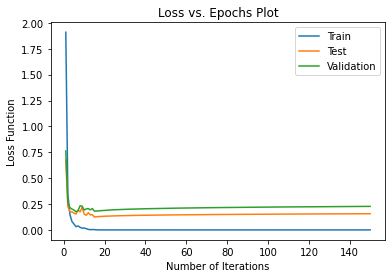

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

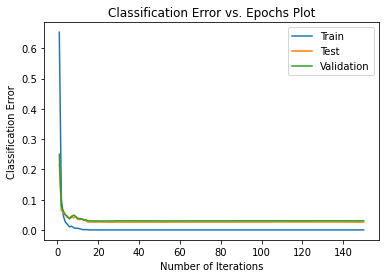

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

### Momentum = 0.9

In [ ]:
# Define HyperParameters
# Number of Classes = 19
num_classes = 19
learning_rate = 0.1 
batch_size = 64
num_epochs = 150
momentum = 0.9
CNN_M9 = CNN1(num_classes).double()

# Batch Datat
train_loader = DataLoader(X_train, batch_size = batch_size)
train_loader_y = DataLoader(Y_train.type(torch.LongTensor), batch_size = batch_size)
test_loader = DataLoader(X_test, batch_size = batch_size)
test_loader_y = DataLoader(Y_test.type(torch.LongTensor), batch_size = batch_size)
val_loader = DataLoader(X_val, batch_size = batch_size)
val_loader_y = DataLoader(Y_val.type(torch.LongTensor), batch_size = batch_size)

# Define Loss & Optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_M9.parameters(), lr = learning_rate, momentum = 0.9)

In [ ]:
start_time = time.time()
test_loss_record = []
train_loss_record =[]
val_loss_record = []
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss_record.append(train_loop7(train_loader,train_loader_y,CNN_M9,loss,optimizer))
    test_loss_record.append(test_loop7(test_loader,test_loader_y,CNN_M9,loss))
    val_loss_record.append(test_loop7(val_loader,val_loader_y,CNN_M9,loss))
print('Done')
print('Total Time Consumed: {}'.format(time.time() - start_time))

Epoch 1
-------------------------------
Training loss: 1.5410210219367797
Training accuracy: 0.49205
Testing loss: 0.49018420762581144
Testing accuracy: 0.8678
Testing loss: 0.5374604767267323
Testing accuracy: 0.848
Epoch 2
-------------------------------
Training loss: 0.4452177769619899
Training accuracy: 0.8762
Testing loss: 0.6788859315557288
Testing accuracy: 0.8304
Testing loss: 0.690787130137702
Testing accuracy: 0.8348
Epoch 3
-------------------------------
Training loss: 0.3582091936714985
Training accuracy: 0.90345
Testing loss: 0.35082074722223044
Testing accuracy: 0.911
Testing loss: 0.39611709609162965
Testing accuracy: 0.9056
Epoch 4
-------------------------------
Training loss: 0.313708302932222
Training accuracy: 0.91785
Testing loss: 0.29488731123114414
Testing accuracy: 0.9182
Testing loss: 0.3443763879100704
Testing accuracy: 0.916
Epoch 5
-------------------------------
Training loss: 0.26955911857291426
Training accuracy: 0.9283
Testing loss: 0.4146247085989643


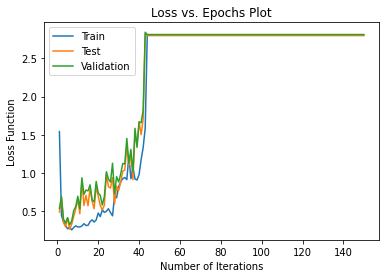

In [ ]:
loss_plot1(train_loss_record, test_loss_record, val_loss_record)

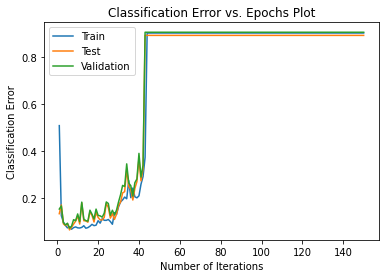

In [ ]:
error_plot1(train_loss_record, test_loss_record, val_loss_record)

## 7.(b)
From above, we can observe the validation error as follow:  
Learning Rate = 0.1: 3.28%;  
Learning Rate = 0.01: 5.76 %;  
Learning Rate = 0.2: 3.04%;  
Learning Rate = 0.5: 2.93%;  
Momentum = 0.5 & Learning Rate = 0.1: 3.02%;  
Momentum = 0.9 & Learning Rate = 0.1: 90.64%.  
Therefore, we choose the model with Learning Rate = 0.5.


## 7.(c)
From above, we can observe the generalization error as follow:  
Learning Rate = 0.1: 3.3%;  
Learning Rate = 0.01: 4.88%;  
Learning Rate = 0.2: 2.54%;  
Learning Rate = 0.5: 2.98%;  
Momentum = 0.5 & Learning Rate = 0.1: 2.58%;  
Momentum = 0.9 & Learning Rate = 0.1: 89.3%.  


Let's assume that the neural network perfectly figure out the summation relationship between the two image digits and label and there is no influence caused by the concatenation of two images. The highest generalization accuracy we can get is 99.3% from convolution neural network in part 4 with momentum = 0.5 & learning rate = 0.1. The probability of two correct classification is 0.993 * 0.993 = 0.986. Therefore, even if our above assumption hold, we still cannot obtain a test error lower than 1%.

# Reference: 
Bloice, M. D., Roth, P. M., &amp; Holzinger, A. (2019, December 6). Performing arithmetic using a neural network trained on digit permutation pairs. arXiv.org. Retrieved April 26, 2022, from https://arxiv.org/abs/1912.03035 
